---
layout: code-post
title: Training neural nets - Initialization
tags: [neural nets]
---

In the [previous notebook](https://kevinnowland.com/code/2020/05/04/backpropagation.html)
I explored training neural nets with backpropagation, and the results were quite
underwhelming. I believe there were a couple big problems. The first is that while I
was having the neural net predict the labels as $\pm1$, the raw output was not 
constrained. I am going to change the output layer to use a sigmoid function
and the predictions to be in $\{0, 1\}$ with the threshold at $0.5$. Along with this,
I will also change the loss function from the hinge loss to the $\ell^2$ loss.
At some point I should explore cross-entropy loss, but today is not that day.

The other, and I suspect larger, issue was the initialization. I naively attempted
to use the Kaiming He initialization without knowing how it actually works. The main
goal of an initialization scheme is to maintain the mean and variance of the input
data across the neural network as well as that of the gradient when backpropagating. In 
other words, with normalized training data, we should
maintain $\mathbb{E}(o_t) = 0$ and while achieving 
$\operatorname{Var}(o_t) = \operatorname{Var}(o_{t-1})$ (element-wise) during the forward 
pass as well as  $\operatorname{Var}(\nabla o_t)=\operatorname{Var}(\nabla o_{t+1})$ 
during backpropogation.


This post is inspired by the initialization post at 
[deeplarning.ai](https://www.deeplearning.ai/ai-notes/initialization/).


Outline:

0. Setup
     - Generating data
     - Base neural net code
1. Initialization
    - Xavier initialization
    - Kaiming He Initializtion
2. Training
    - Example 1
    - Example 2
    - Example 3

## 0. Setup

### Generating Data

We'll generate three different sets of training data. The mean of each coordinate
will be zero and the data will be sparser than what we used previously with
more separation between the positive and zero classes. The mean doesn't actually
have to be zero as we will normalize before passing to the neural net.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import logging

In [69]:
def normalize_data(df, col_names=['x_1', 'x_2']):
    """ return normalized x_1 and x_2 columns """
    return (df[col_names] - df[col_names].mean()) / df[col_names].std()

def train_data_1(random_seed=8):

    np.random.seed(random_seed)

    data_pos_ = np.random.normal(0, 1, size=(50, 2)) - (0, 2.5)
    data_pos = np.array([p for p in data_pos_ if p[1] < p[0] - .25 and p[1] < -p[0] - .25])

    data_neg_1_ = np.random.normal(0, 1, size=(50, 2)) + (0, 2.5)
    data_neg_1 = np.array([p for p in data_neg_1_ if p[1] > p[0] + 0.25 and p[1] > -p[0] + .25])
    data_neg_2_ = np.random.normal(0, 1, size=(50, 2)) + (2.5, 0)
    data_neg_2 = np.array([p for p in data_neg_2_ if p[1] > -p[0] + 0.25 and p[1] < p[0] - .25])
    data_neg_3_ = np.random.normal(0, 1, size=(50, 2)) - (2.5, 0)
    data_neg_3 = np.array([p for p in data_neg_3_ if p[1] > p[0] + 0.25 and p[1] < -p[0] - .25])
    data_neg = np.concatenate((data_neg_1, data_neg_2, data_neg_3))

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)

    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df

def train_data_2(random_seed=3):

    np.random.seed(random_seed)
    
    def rad_sq(array):
        return array[:, 0]**2 + array[:, 1]**2

    data_pos_ = np.random.normal(0, .75, size=(40, 2))
    data_pos = data_pos_[rad_sq(data_pos_) < 4]

    data_neg_ = np.random.uniform(-5, 5, size=(300, 2))
    data_neg = data_neg_[(rad_sq(data_neg_) > 6.25) & (rad_sq(data_neg_) < 16)]

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)

    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df
    
def train_data_3(random_seed=6):

    np.random.seed(random_seed)

    data_pos_ = np.random.uniform(-5, 5, size=(400, 2))
    data_pos =  np.array([p for p in data_pos_ if abs(p[0] - 2.5) < 0.7 or abs(p[0] + 2.5) < 0.7])

    data_neg_ = np.random.uniform(-5, 5, size=(400, 2))
    data_neg = np.array([p for p in data_neg_ if abs(p[0] - 2.5) > 1.25 and abs(p[0] + 2.5) > 1.25])

    data = np.concatenate((data_pos, data_neg), axis=0)
    y = np.concatenate((np.ones(data_pos.shape[0]), np.zeros(data_neg.shape[0])), axis=0)
    
    df = pd.DataFrame({
        'x_1': data[:, 0]
        ,'x_2': data[:, 1]
        ,'y': y
    })
    
    df[['x_1_norm', 'x_2_norm']] = normalize_data(df)
    
    return df

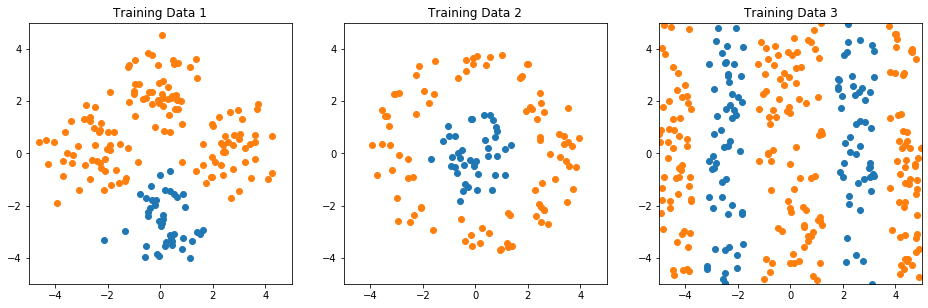

In [71]:
def plot_train_data(df, ax, xlim=None, ylim=None):
    c = df['y'] == 1
    
    if xlim:
        ax.set_xlim(xlim)
    else:
        ax.set_xlim([df['x_1'].min(), df['x_2'].max()])
    
    if ylim:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([df['x_2'].min(), df['x_2'].max()])
        
    ax.plot(df[c]['x_1'], df[c]['x_2'], 'o', label='1')
    ax.plot(df[~c]['x_1'], df[~c]['x_2'], 'o', label='0')
    return ax

fig, ax = plt.subplots(1, 3, figsize=(16, 4.8))

ax[0] = plot_train_data(train_data_1(6), ax[0], [-5, 5], [-5, 5])
ax[1] = plot_train_data(train_data_2(), ax[1], [-5, 5], [-5, 5])
ax[2] = plot_train_data(train_data_3(), ax[2], [-5, 5], [-5, 5])

ax[0].set_title('Training Data 1')
ax[1].set_title('Training Data 2')
ax[2].set_title('Training Data 3')

plt.show()

### Base neural net code

For the Xavier initializations we'll use $\tanh$ and for the Kaiming He
initialization we'll use the $\operatorname{ReLu}$ functions, as that is
what they are derived for. The sigmoid will be for the output.

In [571]:
def relu(x):
    return x * (x>0) + 0 * (x<=0)

def relu_prime(x):
    return 1 * (x>0) + 0 * (x<=0)

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1 - np.power(tanh(x), 2)

def sign(x):
    return 1 * (x > 0) + -1 * (x <= 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def const(x):
    if type(x) == np.ndarray:
        return np.ones(x.shape)
    elif type(x) == list:
        return np.ones(len(x))
    else:
        return 1
    
def const_prime(x):
    if type(x) == np.ndarray:
        return np.zeros(x.shape)
    elif type(x) == list:
        return np.zeros(len(x))
    else:
        return 0


The main difference to the previous `NeuralNet` is that the initialization can
be chosen to be either the Xavier or Kaiming He which we will ensure are within
some small amount of the desired mean and variances. We also remove the
assumption that a column of ones needs to be added to the input in the `_clean_x`
function, as we are removing all biases.

In [572]:
class Neuron():
    """ a neuron with an activation function and its derivative """
    def __init__(self, sigma, sigma_prime):
        self._sigma = sigma
        self._sigma_prime = sigma_prime
        
    @property
    def sigma(self):
        return self._sigma
    
    @property
    def sigma_prime(self):
        return self._sigma_prime
        
    def __str__(self):
        return "Neuron()"
    
class Layer():
    """ a layer of a neural network. The layer assumes that
    every neuron has the same activation function except
    for potentially a constant neuron at the end. If
    being used as an input layer, sigma_prime can be
    left as None. If has_const==True, then the nth
    neuron will be the constant neuron"""
    
    def __init__(self, n, sigma, sigma_prime=None, has_const=False):
        self._neurons = [Neuron(sigma, sigma_prime) for i in range(n)]
        self._has_const = has_const
        
        if has_const:
            self._neurons[-1] = Neuron(const, const_prime)
        
    def __str__(self):
        return "Layer() of {} neurons".format(self.width)
    
    def __repr__(self):
        return self.__str__()
    
    @property
    def neurons(self):
        return self._neurons
    
    @property
    def has_const(self):
        return self._has_const
    
    @property
    def width(self):
        return len(self._neurons)
        
    def output(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma(x[i]) for i in range(len(x))])
    
    def output_prime(self, x):
        assert len(x) == self.width, "input has bad size"
        return np.array([self._neurons[i].sigma_prime(x[i]) for i in range(len(x))])

In [ ]:
class NeuralNet():
    """ a neural net that is constructed from the layers
    it is given. Should be given both an input layer 
    and an output layer. Weights will be initialized
    with the proper shape, but as all ones and zeros. They
    can either be initiated using the function included
    here or set by hand.
    
    With T hidden layers, we have T+2 layers of neurons
    as we have the input and output layers. There are only
    T+1 layers of weights, however, as there are no
    weights from the output layer.
    
    We're going to initialize with Kaiming initializaiton.
    If non-ReLU / ELU is used, set w by hand before training."""
    
    def __init__(self, layer_list, check_w_before_set=True, 
                 init='Xavier', random_seed=None):
        np.random.seed(random_seed)
        
        self._layers = layer_list
        self._checks = check_w_before_set
        
        def get_layer_architecture(l, l_next):
            arch = np.ones(shape=(l_next.width, l.width))
            if l_next.has_const:
                arch[-1,:] = 0
            return arch
            
        self._architecture = [
            get_layer_architecture(self._layers[i], self._layers[i+1])
            for i in range(len(self._layers) - 1)
        ]
        
        def init_weights(i, init):
            """ init weights with either Xavier or Kaiming He initialization 
            If there are biases in this layer, they are initialized to something small"""
            
            if self._layers[i].has_const:
                ncols = self._layers[i].width - 1
            else:
                ncols = self._layers[i].width
                
            if self._layers[i+1].has_const:
                nrows = self._layers[i+1].width - 1
            else:
                nrows = self._layers[i+1].width
                
            mean = 0
            if init == 'Xavier':
                # assumes sigma(a) ~ a for a near zero
                std = np.sqrt(2.0 / (ncols + nrows))
            else:
                # Keiming He init: assumes ReLU
                std = np.sqrt(2.0 / ncols)

            weights = np.random.normal(mean, std, size=(nrows, ncols))
            while abs(np.std(weights)-std) > .05 or abs(np.mean(weights)-mean) > .05:
                weights = np.random.normal(0, std, size=(nrows, ncols))

            w = self._architecture[i].copy() * .1
            w[:nrows, :ncols] = weights
            
            return w

        self._w = [init_weights(i, init) for i in range(len(self._architecture))]
        
    def __str__(self):
        num_hidden = len(self._layers) - 2
        width = np.max([l.width for l in self._layers])
        return "NeuralNet() with {0} hidden layer(s) and width {1}".format(num_hidden, width)
        
    @property
    def layers(self):
        return self._layers
    
    @property
    def architecture(self):
        return self._architecture
        
    @property
    def w(self):
        return self._w
    
    @property
    def check_w_before_set(self):
        return self._checks
    
    def _check_architecture(self, w, a):
        """checks that w has zeros wherever a does """
        inds = np.where(a==0)
        if len(inds[0]) == 0:
            return True
        else:
            return all([w[inds[0][i], inds[1][i]] == 0 for i in range(len(inds[0]))])
    
    @w.setter
    def w(self, w_val):
        if self._checks:
            # check that w_val has proper sizes
            assert len(w_val) == len(self._w), "proposed w has bad length"
            assert all([w_val[i].shape == self._w[i].shape for i in range(len(self._w))]), \
                "proposed w has bad shapes somewhere"
            assert all([self._check_architecture(w_val[i], self._architecture[i]) for i in range(len(self._w))]), \
                "proposed w has bad architecture"
        self._w = w_val
        
    def copy_weights(self):
        return [w.copy() for w in self._w]
        
    def _clean_x(self, x):
        """ take data of form (n_samples, n_features)
        that is either a pandas DataFrame, list, or numpy array
        and convert to numpy array (if needed) and transpose. """
        if type(x) == np.ndarray:
            return x.transpose()
        elif type(x) == pd.DataFrame:
            return x.copy().values.transpose()
        elif type(x) == list:
            return np.array(x).transpose()
    
    def _clean_y(self, y):
        """ take a column vector and make sure it's a numpy column vector """
        if type(y) == np.ndarray:
            return y.reshape(-1, 1)
        elif type(y) == pd.Series:
            return y.values.reshape(-1, 1)
        elif type(y) == list:
            return np.array(y).reshape(-1, 1)
        
        
    def raw_output(self, x, already_cleaned=True):
        """ gets the raw output of the neural network
        
        x needs to have shape (n_samples, n_features)
        without the constant feature appended."""
        
        if already_cleaned:
            raw_output, _, _ = self._forward_pass(x)
        else:
            raw_output, _, _ = self._forward_pass(self._clean_x(x))
        
        return raw_output
    
    def predict(self, x, already_cleaned=True):
        """ gets the 0 or 1 prediction of the neural network """
        z = self.raw_output(x, already_cleaned)
        return 1 * (z >= 0.5) + 0 * (z < 0.5)
    
    def _forward_pass(self, x):
        """ forward pass through the neural network recording
        the outputs and inputs as we go. As an internal
        function, the input x will already be an numpy array
        with shape (n_features+1, n_smples). The +1 is
        for the constant feature."""
        
        # every layer has an input
        a = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
                
        # every layer has an output
        o = [
            np.zeros((l.width, x.shape[0]))
            for l in self._layers
        ]
        
        a[0] = x
        o[0] = self._layers[0].output(a[0])
        
        for i in range(1, len(self._layers)):
            a[i] = np.matmul(self._w[i-1], o[i-1])
            o[i] = self._layers[i].output(a[i])
        
        raw_output = o[-1].transpose()
        
        return raw_output, a, o
    
    def _backward_pass(self, a, o, y):
        """ backward pass through the neural network
        using the forward pass results to calculate the gradient
        as well as the true values which in this case
        are +1 or -1 only. y should be a row vector of
        these values with the same number of columns
        as a[-1] and o[-1], which should have indenticial shapes.
        
        The output is the average gradient for the samples given."""
        
        num_samples = y.shape[1]
        
        # first calculate the sigma_prime values for each hidden + output layer
        sigma_prime = [None] + \
            [self._layers[i].output_prime(a[i]) for i in range(1, len(self._layers))]
        
        # now we start the backward pass for real
        delta = [None] + [np.zeros(a[i].shape) for i in range(1, len(self._layers))]
        z = o[-1] - y
        delta[-1] = z
        
        for i in range(-2, -len(delta)-1, -1):
            # this is w[i+1] bc len(w) = len(delta) - 1
            delta[i] = np.matmul(self._w[i+1].transpose(), (sigma_prime[i+1]) * delta[i+1])
        
        # calculate the average gradient across all samples
        return [
            np.matmul((sigma_prime[i+1] * delta[i+1]), o[i].transpose()) / num_samples
            for i in range(len(self._w))
        ]
    
    def fit(self, x, y, eta=0.1, max_error=0.1, 
            max_epochs=5, batch_size=100, max_iter=None,
            save_data=False, random_seed=None):
        """ use stochastic gradient descent with backpropagation
        to fit the network to the given training data x which
        should be of size (n_samples, n_features),
        y should be of size (n_samples, 1)"""
        
        if random_seed is not None:
            np.random.seed(random_seed)
        
        x_ = self._clean_x(x) # (n_features, n_samples) matrix
        y_ = self._clean_y(y) # column vector
        num_samples = y_.shape[0]
        
        # some samples might be left behind
        batches_per_epoch = np.floor(num_samples / batch_size)
        saved_data = []
        
        w = self.copy_weights()
        
        def calculate_train_error():
            current_predictions = self.predict(x_)
            wrong = np.sum(np.abs(y_ - current_predictions))
            return 1.0 * wrong / num_samples
                    
        curr_iter = 1
        curr_epoch = 1
        curr_batch_number = 0
        batch_indexes = np.arange(num_samples)
        train_error = calculate_train_error()
        
        def get_save_data():
            max_w = np.max([np.max(np.abs(w)) for w in self._w])
            min_w = np.min([np.min(np.abs(w)) for w in self._w])
            current_output = self.raw_output(x_)
            avg_loss = np.mean((current_output - y_)**2)

            return {
                'epoch': curr_epoch
                ,'avg_loss': avg_loss
                ,'train_error': train_error
                ,'max_w': max_w
                ,'min_w': min_w
                ,'w': self.copy_weights()
            }
            
        if save_data:
            saved_data = [get_save_data()]  
            
        keep_training = True   
        while keep_training:
            
            if curr_batch_number == 0:
                # re-shuffle indexes as neded
                logging.debug("NeuralNet.fit(): starting epoch {}".format(curr_epoch))
                np.random.shuffle(batch_indexes)
                
            batch_ind = batch_indexes[curr_batch_number * batch_size:(curr_batch_number + 1) * batch_size]
            
            x_batch = x_[:, batch_ind]
            y_batch = y_[batch_ind,:]
            
            # forward pass
            _, a, o = self._forward_pass(x_batch)
            
            # backward pass
            grad = self._backward_pass(a, o, y_batch.transpose())
            
            w = [w[i] - eta * grad[i] for i in range(len(w))]
            self.w = [
                (curr_iter * self._w[i] + w[i]) / (curr_iter + 1)
                for i in range(len(self._w))
            ]
            
            train_error = calculate_train_error()
            curr_iter += 1
            curr_batch_number = int((curr_batch_number + 1) % batches_per_epoch)
            
            if curr_batch_number == 0:
                curr_epoch += 1
                
                if save_data:
                    saved_data += [get_save_data()]
                    
            keep_training = train_error >= max_error and curr_epoch <= max_epochs
            if max_iter is not None:
                keep_training = keep_training and curr_iter <= max_iter
            
            
        if curr_epoch > max_epochs:
            logging.warning("NeuralNet.fit():no convergence, train_error above max_error")
        else:
            logging.warning("NeuralNet.fit(): converged during epoch {}.".format(curr_epoch-1))
        
        if save_data:
            return saved_data
        else:
            return None
        

## 1. Initialization


### Xavier initialization 

The theoretical understanding behind what has come to be known as 
_Xavier initializaiton_ was presented by Xavier Glorot and Bengio in 
[Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).
Under the assumptions that input data is normalized and that the activation functions
at each layer satisfy $\sigma(0)=0$ and $\sigma'(0)=1$, i.e., that $\sigma(a)\approx a$
for small $a$, they show that maintaining the variance of the outputs at each layer
during the feedforward process requires the variance of the weights in $W^t$ mapping the
outputs of layer $t$ to layer $t+1$ to have variance $1/n_t$. During the backprpopration
portion, the desired variance of the weights is $1/n_{t+1}$. They actually propose
using the harmonic mean, $2/(n_t + n_{t+1})$. 

At the time of writing in 2010, the authors note that the standard initialization
scheme was for the weights to be drawn from $U\left[-\frac{1}{\sqrt{n_t}},\frac{1}{\sqrt{n_t}}\right]$
which has variance $1/3n_t$. Building from this, they propose the weights in $W_t$
be initialized according to $U\left[-\sqrt{\frac{6}{n_t+n_{t+1}}}, \sqrt{\frac{6}{n_t+n_{t+1}}}\right]$.
We will follow the more modern convention and sample from $\mathcal{N}(0, \frac{2}{n_t+n_{t+1}})$.
I have not read about whether this improves performance or why, but I suspect that more samples
will be clustered around 0 thus preserving the approxomation of the activation function
in more cases. The risk of course is that a sample can be drawn arbitrarily far from 0.

### Kaiming He Initialization

The Kaiming He initialization was presented in the paper 
[Delving deep into rectifiers](https://arxiv.org/abs/1502.01852) from 2015
by He et al. specifically for ReLU activation functions. The ReLU functions do not satisfy
the property that they are approximately the identity at the origin, and thus Xavier's initialization
should not a priori be useful. In the introduction to the paper, the authors note that
ReLU type activations compared to the sigmoid like activations, such as the $\tanh$ function we 
were using above.

For ReLU functions, the forward pass leads to initializing weights by sampling from
a Gaussian distribution with mean zero and variance $\frac{2}{n_t}$ while the backward
propogation leads to variance $\frac{2}{n_{t+1}}$. The factors of two in each case come about from different reasons,
either from the fact that the derivative of the ReLU function has equal probability of
being 1 or 0 (if its input is symmetric about zero) or from the expectation of
the square of a ReLU function being half the variation of its input. Importantly, the authors
note that both choices will prevent gradient blowup. They also their derive initialization scheme
without biases.

## 2. Examples

We are going to make a child class of `NeuralNet` that encapsulates 
the simpler setup we will be using. Namely, we standardize the input
to two dimensions, remove all biases, only allow for a single
activator function, and use the sigmoid for the single output.

In [593]:
class SingleActivatorNN (NeuralNet):
    """ Simpler neural net in that we require all
    hidden layers to use the same activation function
    and the output to be a single sigmoid activator. 
    The input must also be two-dimensional. """
    
    def __init__(self, hidden_layer_widths, 
                 sigma, sigma_prime, init='Xavier', 
                 random_seed=47, has_bias=False):
        if has_bias:
            layer_list = [Layer(3, lambda x: x, None, has_bias)]
        else:
            layer_list = [Layer(2, lambda x: x, None, has_bias)]
        layer_list += [
            Layer(n, sigma, sigma_prime, has_bias)
            for n in hidden_layer_widths
        ]
        layer_list += [Layer(1, sigmoid, sigmoid_prime, False)]
        
        super().__init__(layer_list, init=init, random_seed=random_seed)

Immediately below this is a too long series of functions that are used to plot
information related to the training of the tewo neural networks.

In [596]:
def plot_background(ax, nn, alpha=.1, has_bias=False):
    """ plots 100^2 points on [-5,5]^2 grid colored
    based on the raw output from the neural net """
    
    # get grid of points
    x = np.linspace(-5, 5, 100)
    xy = product(x, x)
    df_background = pd.DataFrame(xy, columns=['x_1', 'x_2'])
    
    if has_bias:
        df_background['const'] = 1
    
    # normalize
    df_background[['x_1_norm', 'x_2_norm']] = normalize_data(df_background)

    if has_bias:
        y_raw = nn.raw_output(df_background[['x_1_norm', 'x_2_norm', 'const']], False)
    else:
        y_raw = nn.raw_output(df_background[['x_1_norm', 'x_2_norm']], False)
        
    df_background['predict_proba'] = y_raw
        
    
    # plotting
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    
    ax.scatter(df_background['x_1'],
               df_background['x_2'],
               c=df_background['predict_proba'],
               cmap='RdYlBu',
               marker='o',
               alpha=alpha)
    
    return ax

def plot_predictions(ax, nn, df):
    if 'const' in df.columns:
        ax = plot_background(ax, nn, has_bias=True)
    else:
        ax = plot_background(ax, nn, has_bias=False)
    
    df_ = df.copy()
    
    if 'const' in df.columns:
        df_['pred'] = nn.predict(df_[['x_1_norm', 'x_2_norm', 'const']], False)
    else:
        df_['pred'] = nn.predict(df_[['x_1_norm', 'x_2_norm']], False)
    
    c_tp = (df_['y'] == 1) & (df_['pred'] == 1)
    c_fp = (df_['y'] == 0) & (df_['pred'] == 1)
    c_fn = (df_['y'] == 1) & (df_['pred'] == 0)
    c_tn = (df_['y'] == 0) & (df_['pred'] == 0)
    
    # should be positive
    ax.scatter(df_[c_tp]['x_1'], df_[c_tp]['x_2'], marker='o',
               s=50, c='C0', label='TP')
    ax.scatter(df_[c_fn]['x_1'], df_[c_fn]['x_2'], marker='o',
               s=50, facecolors='none', edgecolors='C0', label='FN')
    
    # should be negative
    ax.scatter(df_[c_tn]['x_1'], df_[c_tn]['x_2'], marker='o',
               s=50, c='C1', label='TN')
    ax.scatter(df_[c_fp]['x_1'], df_[c_fp]['x_2'], marker='o',
               s=50, facecolors='none', edgecolors='C1', label='FP')
    
    ax.legend(loc='upper right', facecolor='white', framealpha=1)
    
    return ax

def plot_training_info(nn_tanh, nn_relu, data_tanh, data_relu, df_train):
    """ function to plot training information about two neural nets,
    one which should have tanh activtors with Xavier's initialization
    and another that should have ReLU activators with He's initilization."""

    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    ax[0, 0] = plot_predictions(ax[0, 0], nn_tanh, df_train)
    ax[0, 0].set_title("Final Predictions: tanh activators; Xavier's initialization")

    ax[0, 1] = plot_predictions(ax[0, 1], nn_relu, df_train)
    ax[0, 1].set_title("Final Predictions: ReLU activators; He's initialization")

    ax[1, 0].plot([d['train_error'] for d in data_tanh], label='tanh')
    ax[1, 0].plot([d['train_error'] for d in data_relu], label='relu')
    ax[1, 0].set_title('Train Error')
    ax[1, 0].set_xlabel('epoch')
    ax[1, 0].legend(loc='upper right')

    ax[1, 1].plot([d['avg_loss'] for d in data_tanh], label='tanh')
    ax[1, 1].plot([d['avg_loss'] for d in data_relu], label='relu')
    ax[1, 1].set_title('$\ell^2$ loss')
    ax[1, 1].set_xlabel('epoch')
    ax[1, 1].legend(loc='upper right')

    plt.show()

### Example 1

Now let's actually get to training! In this example we'll see how swapping the
activators from $\tanh$ to $\operatorname{ReLU}$ leads to effective training.
For the first set of training data, the training points are roughly
radially symmetric, so we expect training to go fairly smoothly.

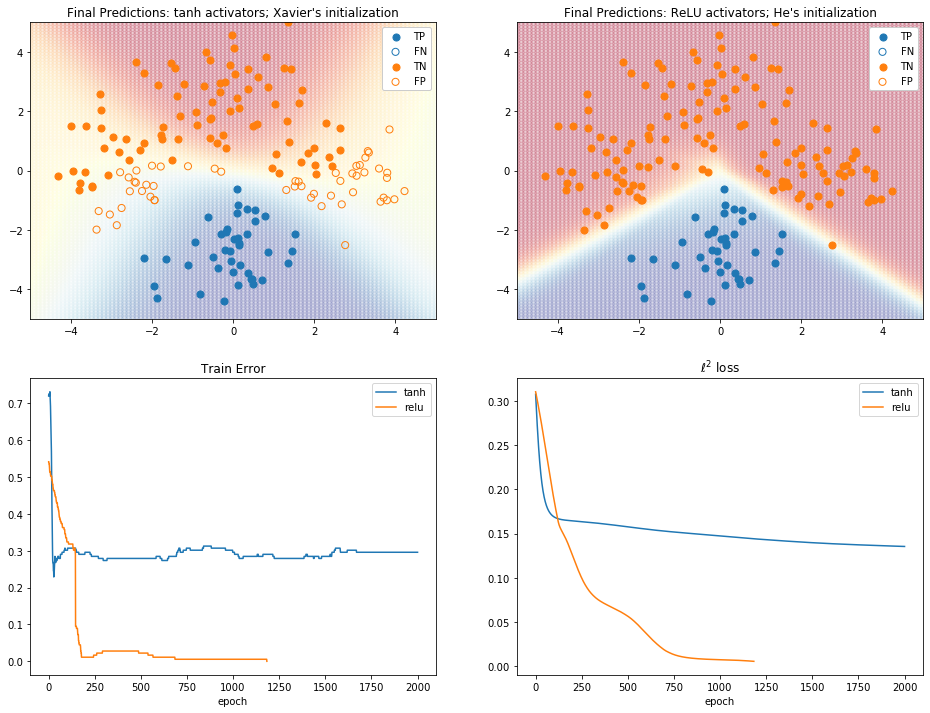

In [597]:
random_seed = 3
nn_tanh_1 = SingleActivatorNN([6, 3], tanh, tanh_prime, 'Xavier', random_seed)
nn_relu_1 = SingleActivatorNN([6, 3], relu, relu_prime, 'He', random_seed)

train_1 = train_data_1()
features = ['x_1_norm', 'x_2_norm']

train_params = {
    'x': train_1[features]
    ,'y': train_1['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': train_1.shape[0]
    ,'save_data': True
}

data_tanh_1 = nn_tanh_1.fit(**train_params)
data_relu_1 = nn_relu_1.fit(**train_params)

plot_training_info(nn_tanh_1, nn_relu_1, data_tanh_1, data_relu_1, train_1)

In the top row, the backround is colorized according to the `raw_output` of the neural net.
The color of the points matches the classes that should be predicted, while filled points are
correctly predicted. Unfrotunately the colorization is a little off from the
predicted output, i.e., some slighty blue alreas actually lead to orange predictions.

It seems clear that this architecture does not work with $\tanh$ as the activator
functions. Perhaps some more width or another layer would help, but we won't
do that in this notebook. The nice feature though is that we are succesfully
training for many epochs in both cases.

### Example 2

For the second example, we maintain the radial symmetry, but the
positive points are encircled by the negative points. In neither
case does training complete.

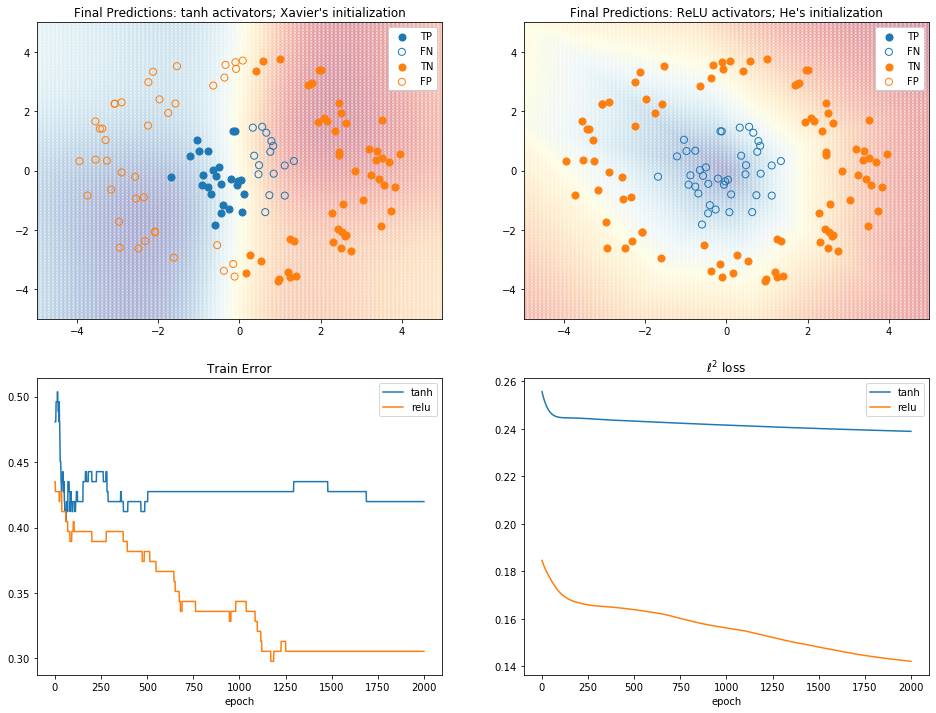

In [528]:
random_seed = 3
nn_tanh_2 = SingleActivatorNN([6, 3], tanh, tanh_prime, 'Xavier', random_seed)
nn_relu_2 = SingleActivatorNN([6, 3], relu, relu_prime, 'He', random_seed)

train_2 = train_data_2()
features = ['x_1_norm', 'x_2_norm']

train_params = {
    'x': train_2[features]
    ,'y': train_2['y']
    ,'eta': .25
    ,'max_error': 0.0001
    ,'max_epochs': 2000
    ,'batch_size': train_2.shape[0]
    ,'save_data': True
}

data_tanh_2 = nn_tanh_2.fit(**train_params)
data_relu_2 = nn_relu_2.fit(**train_params)

plot_training_info(nn_tanh_2, nn_relu_2, data_tanh_2, data_relu_2, train_2)

The ReLU is doing okay, but not actually predicting any of the positive class. Let's crank up
the learning rate and the number of epochs and see what happens after way too long.

/anaconda2/envs/gitpage/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


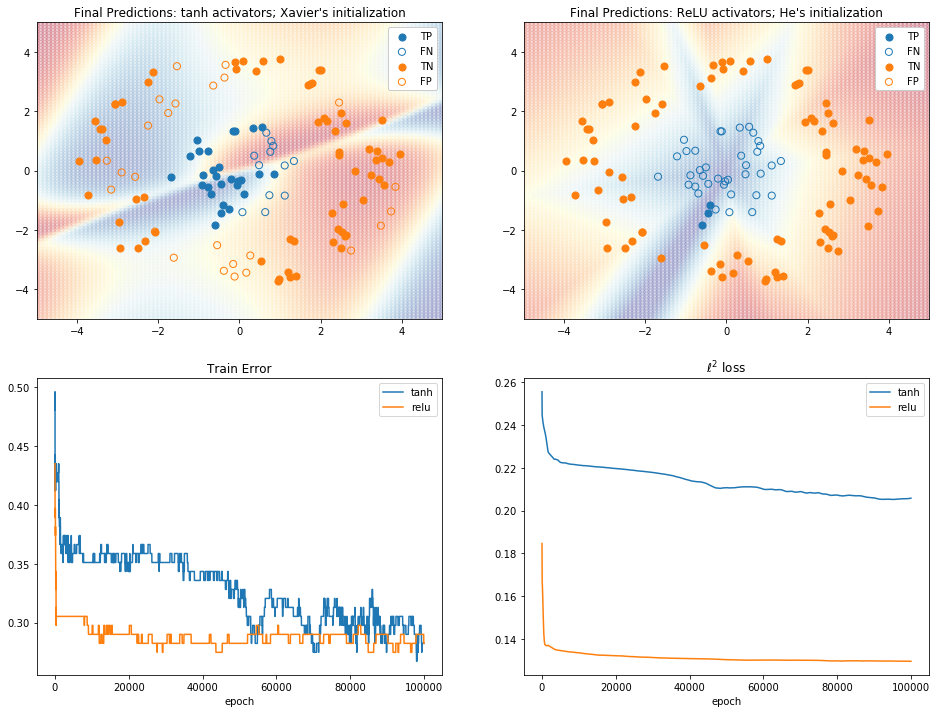

In [530]:
random_seed = 3
nn_tanh_2b = SingleActivatorNN([6, 3], tanh, tanh_prime, 'Xavier', random_seed)
nn_relu_2b = SingleActivatorNN([6, 3], relu, relu_prime, 'He', random_seed)

train_2 = train_data_2()
features = ['x_1_norm', 'x_2_norm']

train_params = {
    'x': train_2[features]
    ,'y': train_2['y']
    ,'eta': 1
    ,'max_error': 0.0001
    ,'max_epochs': 100_000
    ,'batch_size': train_2.shape[0]
    ,'save_data': True
}

data_tanh_2b = nn_tanh_2b.fit(**train_params)
data_relu_2b = nn_relu_2b.fit(**train_params)

plot_training_info(nn_tanh_2b, nn_relu_2b, data_tanh_2b, data_relu_2b, train_2)

And here it's possible to see the beginning of overtraining in the $\operatorname{ReLU}$ case as it picks up
the artificial gap in the outer layer of points.

## Example 3

### Without biases

Finally, we will break the radial symmetry in the final traning example which we think should cause
problems due to the lack of biases. We'll use more epochs and a higher learning rate.

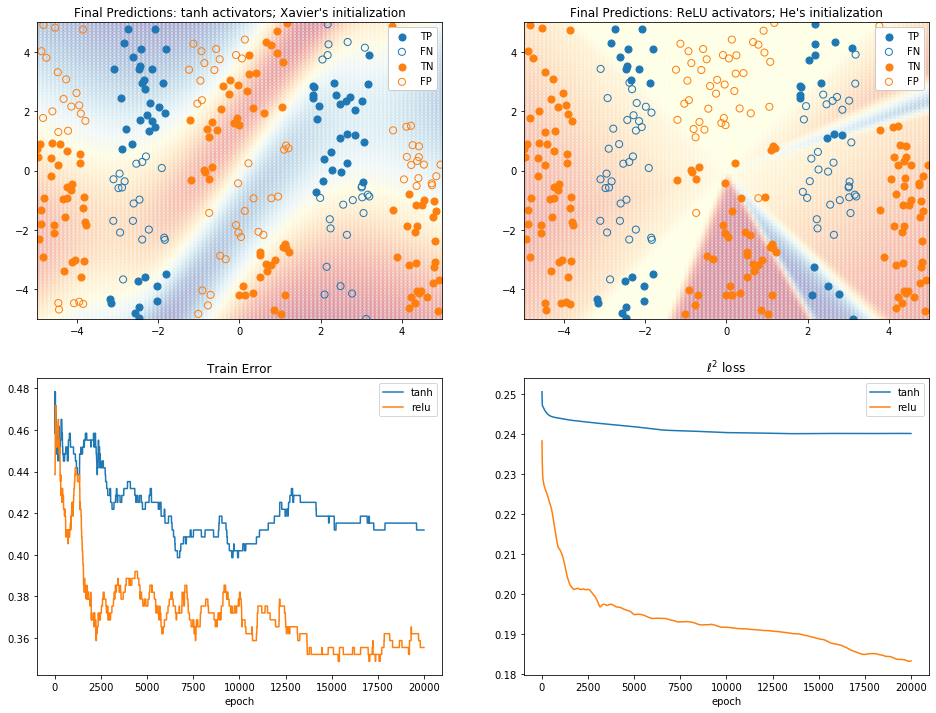

In [533]:
random_seed = 3
nn_tanh_3 = SingleActivatorNN([6, 3], tanh, tanh_prime, 'Xavier', random_seed)
nn_relu_3 = SingleActivatorNN([6, 3], relu, relu_prime, 'He', random_seed)

train_3 = train_data_3()
features = ['x_1_norm', 'x_2_norm']

train_params = {
    'x': train_3[features]
    ,'y': train_3['y']
    ,'eta': 1
    ,'max_error': 0.0001
    ,'max_epochs': 20000
    ,'batch_size': train_3.shape[0]
    ,'save_data': True
}

data_tanh_3 = nn_tanh_3.fit(**train_params)
data_relu_3 = nn_relu_3.fit(**train_params)

plot_training_info(nn_tanh_3, nn_relu_3, data_tanh_3, data_relu_3, train_3)

And now, because it's so easy to do so, let's just add a bunch of layers and see what happens.

/anaconda2/envs/gitpage/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


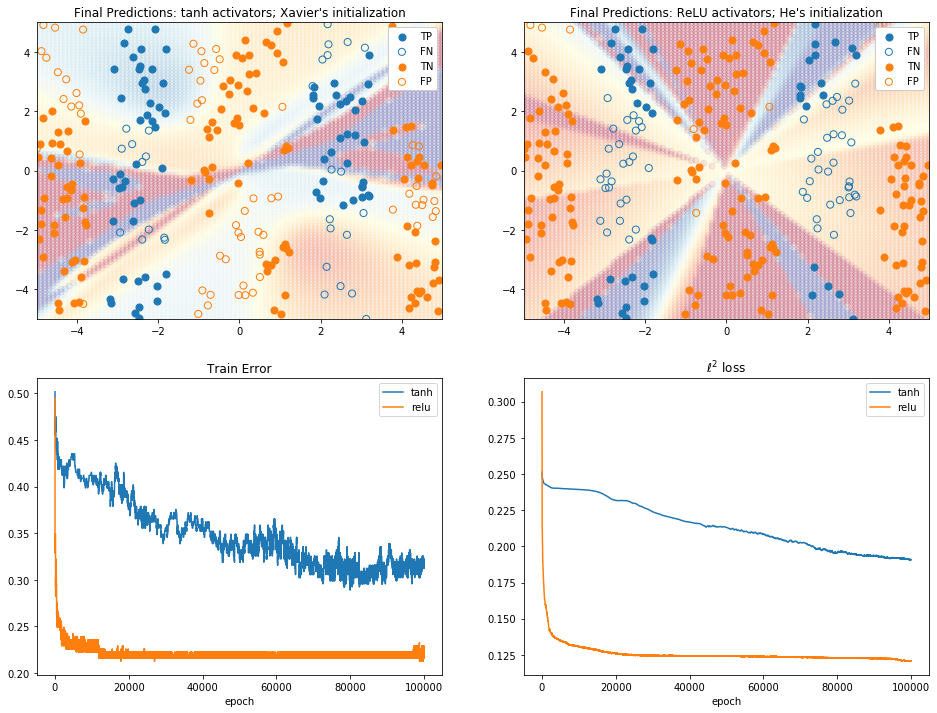

In [535]:
random_seed = 3
nn_tanh_3b = SingleActivatorNN([10, 10, 10, 10, 5], tanh, tanh_prime, 'Xavier', random_seed)
nn_relu_3b = SingleActivatorNN([10, 10, 10, 10, 5], relu, relu_prime, 'He', random_seed)

train_3 = train_data_3()
features = ['x_1_norm', 'x_2_norm']

train_params = {
    'x': train_3[features]
    ,'y': train_3['y']
    ,'eta': 1
    ,'max_error': 0.0001
    ,'max_epochs': 100000
    ,'batch_size': train_3.shape[0]
    ,'save_data': True
}

data_tanh_3b = nn_tanh_3b.fit(**train_params)
data_relu_3b = nn_relu_3b.fit(**train_params)

plot_training_info(nn_tanh_3b, nn_relu_3b, data_tanh_3b, data_relu_3b, train_3)

The $\operatorname{ReLU}$ is again obviously overfitting, as it's taking sending out rays from the origin
in small spots to get good predictions. 

### With biases

Let's see what happens if we initialize with biases. The bias terms are initialized with weights that
are constantly 1, and the initilialization schemes do not take the rows / columns feeding form or
into biased neurons into account when selecting the initial weights.

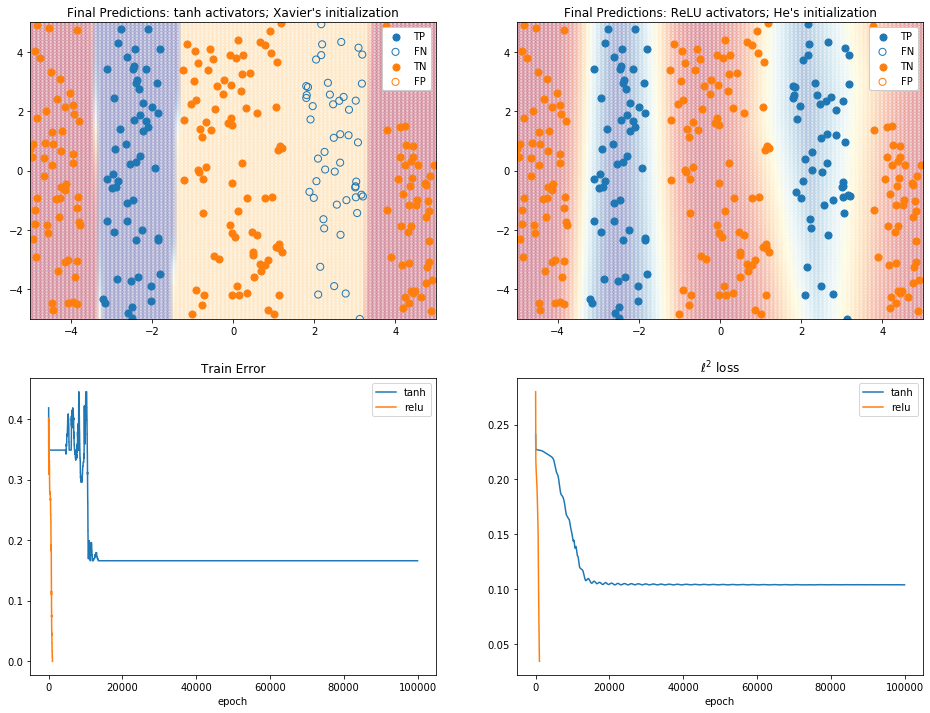

In [604]:
random_seed = 10
nn_tanh_3b = SingleActivatorNN([6, 3], tanh, tanh_prime, 'Xavier', random_seed, True)
nn_relu_3b = SingleActivatorNN([6, 3], relu, relu_prime, 'He', random_seed, True)

train_3 = train_data_3()
train_3['const'] = 1
features = ['x_1_norm', 'x_2_norm', 'const']

train_params = {
    'x': train_3[features]
    ,'y': train_3['y']
    ,'eta': 1
    ,'max_error': 0.0001
    ,'max_epochs': 100_000
    ,'batch_size': train_3.shape[0]
    ,'save_data': True
}

data_tanh_3b = nn_tanh_3b.fit(**train_params)
data_relu_3b = nn_relu_3b.fit(**train_params)

plot_training_info(nn_tanh_3b, nn_relu_3b, data_tanh_3b, data_relu_3b, train_3)